In [2]:
# Cell 1: Import Libraries
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Load and Filter Survey Data
survey_data = pd.read_csv('Data/survey_data_modified.csv')
survey_data_matched = survey_data.loc[survey_data['Area (in Ha.)'] == survey_data['effective_area']]

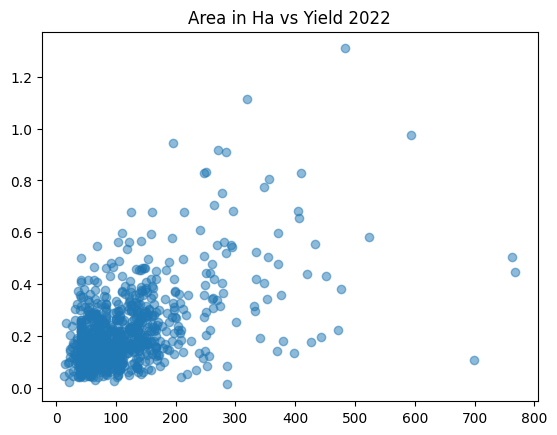

In [4]:
# Cell 3: Plot Yield vs Area for Matched Plots
plt.scatter(survey_data_matched['yield22'], survey_data_matched['Area (in Ha.)'], alpha=0.5)
plt.title("Area in Ha vs Yield 2022")
plt.show()

In [5]:
# Load and Preprocess Shapefile Data
gdf = gpd.read_file('Data/shapefiles_new/output_polygon_shapefile.shp')
print(gdf.columns)

#gdf = gdf.to_crs(epsg = 32644)

gdf['calculated_area'] = gdf.geometry.area * 1000000.0

gdf.rename(columns={'effective_':'effective_area'}, inplace=True)
"""print(gdf['calculated_area'].head(5))
print(gdf['effective_area'].head(5))"""
# Filtering with 10% error margin
gdf = gdf.loc[(gdf['effective_area'] <= gdf['calculated_area'] * 1.25) & (gdf['effective_area'] >= gdf['calculated_area'] * 0.75)]    #ERROR RATE OF 25%
gdf.reset_index(drop=True, inplace=True)
gdf

Index(['Village Co', 'Village Na', 'farmer_cod', 'Farmer Nam', 'Father's N',
       'Plot Numbe', 'Area (in H', 'Croptype C', 'Croptype D', 'Variety Gr',
       'Variety Co', 'Date of Pl', 'Lat1', 'Long1', 'Lat2', 'Long2', 'Lat3',
       'Long3', 'Lat4', 'Long4', 'ugc_code', 'yield22', 'effective_',
       'geometry'],
      dtype='object')


/var/folders/bf/22f78p4d19b_rj2bpzzzkn4r0000gn/T/ipykernel_3153/1636764063.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['calculated_area'] = gdf.geometry.area * 1000000.0


,Village Co,Village Na,farmer_cod,Farmer Nam,Father's N,Plot Numbe,Area (in H,Croptype C,Croptype D,Variety Gr,...,Long2,Lat3,Long3,Lat4,Long4,ugc_code,yield22,effective_area,geometry,calculated_area
0,160,BHILAWAN,16000254,CHIRAUNJI,DUJA,290016000104701,0.212,15,SPRING,EARLY,...,80.089712,27.854358,80.089567,27.854038,80.090385,51313585810113,41.88,0.160,"POLYGON ((80.09049 27.85422, 80.09038 27.85404...",0.192558
1,160,BHILAWAN,16000255,SADHU,KEDARI,290016000107701,0.427,15,SPRING,EARLY,...,80.091708,27.854363,80.092551,27.854009,80.092309,51313585810114,41.93,0.410,"POLYGON ((80.09149 27.85432, 80.09171 27.85471...",0.388157
2,160,BHILAWAN,16000213,SRI PAL,DUJA,290016000104601,0.283,15,SPRING,EARLY,...,80.089842,27.854514,80.089693,27.854229,80.090508,51313585810072,69.70,0.283,"POLYGON ((80.09063 27.85447, 80.09051 27.85423...",0.257726
3,160,BHILAWAN,16000253,RAMESHWAR,CHHATTAR,290016000102401,0.217,12,RATOON-1,EARLY,...,80.092036,27.854436,80.092351,27.854948,80.092703,51313585810112,41.53,0.230,"POLYGON ((80.09240 27.85505, 80.09270 27.85495...",0.194753
4,161,MATHWAL DEVTA,16106089,FIROJA,AASH MOHAMMAD,290016100256101,0.372,13,AUTUMN,EARLY,...,80.083809,27.788230,80.084203,27.788332,80.083864,51313589510200,109.99,0.372,"POLYGON ((80.08338 27.78757, 80.08386 27.78833...",0.331104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,9209,KARAWAN,920900762,GAYA PRASAD,MAKRAND,290920900338301,0.108,13,AUTUMN,EARLY,...,80.145833,27.675416,80.145459,27.675232,80.145304,53013928310306,70.78,0.108,"POLYGON ((80.14565 27.67503, 80.14530 27.67523...",0.096913
1065,9209,KARAWAN,920900213,ASHA SINGH,SURENDRA BAHADUR,290920900334801,0.522,12,RATOON-1,EARLY,...,80.138574,27.674984,80.139375,27.675530,80.139731,53013928310074,265.67,0.424,"POLYGON ((80.13877 27.67576, 80.13973 27.67553...",0.466777
1066,9209,KARAWAN,920900682,BICHITRA VEER SINGH,CHHOTEY SINGH,290920900327602,0.387,15,SPRING,EARLY,...,80.135568,27.677895,80.135436,27.677423,80.136858,53013928310228,150.29,0.387,"POLYGON ((80.13700 27.67761, 80.13686 27.67742...",0.388474
1067,9209,KARAWAN,920900396,AHIVARAN,RAM LAL,290920900327001,0.292,15,SPRING,EARLY,...,80.137557,27.677681,80.137387,27.677930,80.136869,53013928310111,98.80,0.250,"POLYGON ((80.13721 27.67838, 80.13756 27.67817...",0.262001


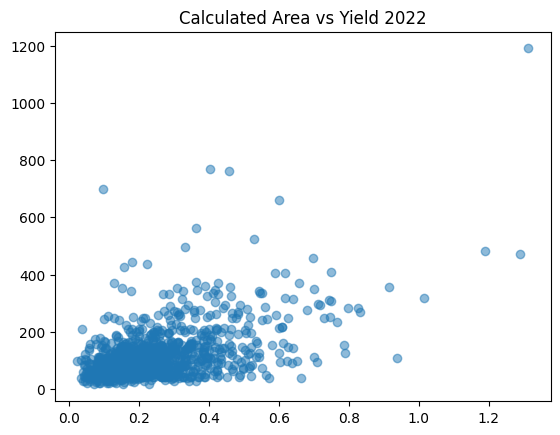

In [6]:
# Scatter Plot of Calculated Area vs Yield for 2023
plt.scatter(gdf['calculated_area'], gdf['yield22'], alpha=0.5)
plt.title("Calculated Area vs Yield 2022")
plt.show()

In [7]:
# Cell 6: Reproject GeoDataFrame for Consistency with TIFF Images
#gdf = gdf.to_crs("EPSG:4326")

In [8]:
# Directory where your TIFF images are stored and where to save the extracted plots
tiff_directory = 'Data/convex_hull'
output_directory = 'Data/plotwise_monthly'

# List of TIFF files
tiff_files = [
    'sentinel_mosaic_1.tif', 'sentinel_mosaic_2.tif', 'sentinel_mosaic_3.tif',
    'sentinel_mosaic_4.tif', 'sentinel_mosaic_5.tif', 'sentinel_mosaic_6.tif', 'sentinel_mosaic_7.tif',
    'sentinel_mosaic_8.tif', 'sentinel_mosaic_9.tif', 'sentinel_mosaic_10.tif',
    'sentinel_mosaic_11.tif', 'sentinel_mosaic_12.tif'
]

In [9]:
def extract_area(tiff_path, gdf):
    with rasterio.open(tiff_path) as src:
        geom = [gdf.geometry.values[0].__geo_interface__]
        # Perform the mask operation, which should retain all bands
        out_image, out_transform = mask(src, geom, crop=True, all_touched=True)
        #Update the metadata for the output file
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform})
        return out_image, out_meta

In [10]:
def normalize_array(arr):
    print(arr.shape)
    # Calculate the maximum value along the third dimension (bands)
    max_vals = np.max(arr, axis=(0,1), keepdims=True)
    print(max_vals)
    # Calculate the minimum value along the third dimension (bands)
    min_vals = np.min(arr, axis=(0,1), keepdims=True)
    # Normalize each band using the min-max normalization formula
    normalized_arr = (arr - min_vals) / (max_vals - min_vals)
    return normalized_arr

In [11]:
# Iterate over each row in the GeoDataFrame
for index, row in gdf.iterrows():
    # Create a directory for each plot using the 'ugc_code' value
    plot_directory = os.path.join(output_directory, str(row['ugc_code']))
    """Data/plotwise_monthly/UGC_CODE"""
    #Making multiple directories named after the ugc code.
    os.makedirs(plot_directory, exist_ok=True)
    
    # Create a temporary GDF for the current plot
    current_gdf = gdf.iloc[[index]]
    
    # Loop through each TIFF file and extract the area for the current plot
    for tiff_file in tiff_files:
        tiff_path = os.path.join(tiff_directory, tiff_file)
        """Data/convex_hull/sentinel_mosaic_1.tif"""
        out_image, out_meta = extract_area(tiff_path, current_gdf)
        output_tiff_path = os.path.join(plot_directory, f"{tiff_file}")
        # Save the extracted image to a new TIFF file in the plot-specific directory
        with rasterio.open(output_tiff_path, 'w', **out_meta) as dest:
            for band in range(out_image.shape[0]):  # Loop through each band
                dest.write(out_image[band], band + 1)  # Bands are 1-indexed in TIFF files

print("Extraction completed.")

Extraction completed.


In [13]:
# Calculate NDVI for a single image
def calculate_ndvi(image_path):
    with rasterio.open(image_path) as src:
        # Assuming B4 (Red) is the 4th band and B8 (NIR) is the 8th band
        red = src.read(4)  # Band 4 for Red
        nir = src.read(8)  # Band 8 for NIR
        # Avoid division by zero
        np.seterr(divide='ignore', invalid='ignore')
        # Calculate NDVI
        ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
        return ndvi

# Function to save NDVI as a TIFF image
def save_ndvi_image(ndvi_array, save_path, reference_meta):
    with rasterio.open(save_path, "w", **reference_meta) as dest:
        dest.write(ndvi_array.astype(rasterio.float32), 1)

In [45]:
column_names = ['ugc_code', 'ndvi_1', 'ndvi_2', 'ndvi_3', 'ndvi_4', 'ndvi_5', 'ndvi_6','ndvi_7', 'ndvi_8', 'ndvi_9', 'ndvi_10', 'ndvi_11', 'ndvi_12', 'ndvi_avg', 'yield22']
final_ndvi = pd.DataFrame(columns=column_names)
base_directory = 'Data/plotwise_monthly'
tiff_files = [
    'sentinel_mosaic_1.tif', 'sentinel_mosaic_2.tif', 'sentinel_mosaic_3.tif',
    'sentinel_mosaic_4.tif', 'sentinel_mosaic_5.tif', 'sentinel_mosaic_6.tif', 'sentinel_mosaic_7.tif',
    'sentinel_mosaic_8.tif', 'sentinel_mosaic_9.tif', 'sentinel_mosaic_10.tif',
    'sentinel_mosaic_11.tif', 'sentinel_mosaic_12.tif'
]
ugc_codes = []
for ugc_code_dir in os.listdir(base_directory):
    ugc_code_path = os.path.join(base_directory, ugc_code_dir)
    add_new = [ugc_code_dir]  # Start list with ugc_code
    ndvi_values = []

    if os.path.isdir(ugc_code_path):
        for file_name in tiff_files:  # Ensure files are processed in order
            if file_name in os.listdir(ugc_code_path):
                file_path = os.path.join(ugc_code_path, file_name)
                ndvi = calculate_ndvi(file_path)
                
                compressed_ndvi = np.ma.masked_invalid(ndvi).compressed()
                mean_ndvi = compressed_ndvi.mean() if compressed_ndvi.size > 0 else np.nan
                ndvi_values.append(mean_ndvi)
                
        add_new.extend(ndvi_values)  
        add_new.append(np.nanmean(ndvi_values))  # Calculate the average NDVI excluding NaNs
        add_new.append(gdf['yield22'].loc[gdf['ugc_code'] == int(ugc_code_dir)].values[0])
        final_ndvi.loc[len(final_ndvi)] = add_new  # Append the row to the DataFrame

final_ndvi = final_ndvi.loc[final_ndvi['ndvi_avg'].notna()]

final_ndvi

,ugc_code,ndvi_1,ndvi_2,ndvi_3,ndvi_4,ndvi_5,ndvi_6,ndvi_7,ndvi_8,ndvi_9,ndvi_10,ndvi_11,ndvi_12,ndvi_avg,yield22
0,53113933110378,29.048173,25.849962,0.137246,0.168713,0.081221,0.136259,31.627683,76.971763,61.091249,24.198875,1.533083,3.286838,21.177589,104.59
1,53113929810191,30.988107,27.086915,0.109218,0.300792,21.627025,8.528811,20.641361,67.816919,62.902721,38.930277,31.820351,0.459596,25.934341,55.69
2,53113929710189,29.831435,29.529731,1.806100,0.217853,31.455637,53.937469,38.365540,69.598711,57.709581,54.225474,29.790457,22.134645,34.883553,98.01
3,43013432810231,26.889659,29.419589,0.093639,0.109767,4.389610,4.288447,NaN,83.794682,70.927769,15.224565,5.023863,0.017157,21.834431,99.55
4,53113912110306,25.246427,22.223537,7.085228,0.181755,15.699399,3.444314,NaN,65.626160,54.229860,43.055377,24.332744,0.015962,23.740069,113.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,53113937210250,37.907757,58.095569,28.883976,0.183886,15.372846,4.339065,19.071118,56.948443,61.213266,9.176589,63.300439,33.362640,32.321299,167.27
1064,53113914510052,27.063204,35.440062,29.691684,0.208793,20.149526,13.584813,NaN,57.334209,61.069633,44.356227,44.129457,0.017908,30.276865,41.58
1065,53113910910126,24.459807,38.153027,46.217415,0.552557,0.107604,0.156364,NaN,56.100277,46.951139,0.128807,44.524965,0.478922,23.439171,22.57
1066,53113911710122,29.410991,27.823368,0.130546,0.142472,17.526933,0.131907,NaN,61.043080,38.954584,20.766721,25.303548,6.556199,20.708214,83.76


/Users/sakarth/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sakarth/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sakarth/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/sakarth/PycharmProjects/pythonProject/venv/lib/py

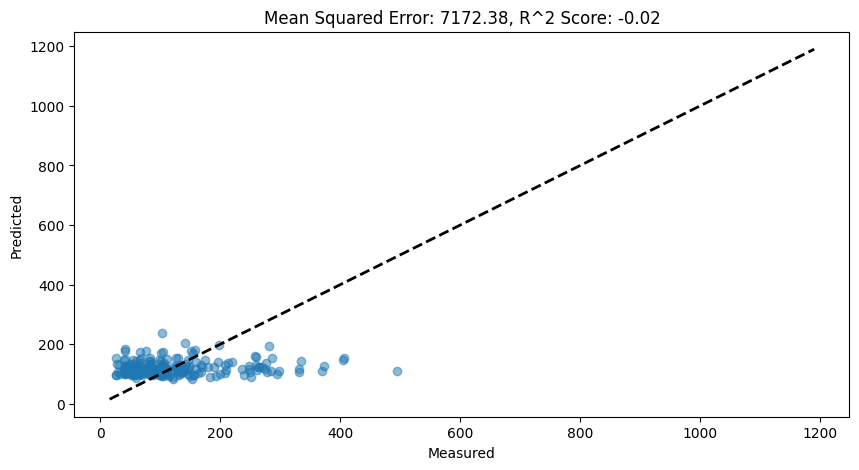

Best Parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 200}
Mean Squared Error: 7172.381371793492
R^2 Score: -0.019980720206123292


In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and prepare your data
# Assuming final_ndvi is already loaded and preprocessed
X = final_ndvi.drop(columns=['ugc_code', 'ndvi_7','ndvi_1','ndvi_avg', 'yield22'])  # Exclude non-NDVI columns and ndvi_7
y = final_ndvi['yield22']

# Adding polynomial features to capture non-linear interactions
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Hyperparameter tuning setup
param_grid = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt'],
    'randomforestregressor__max_depth': [None, 10, 20],
}

# Creating a pipeline
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
grid_search = GridSearchCV(pipeline, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Evaluating the best model
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # A line showing perfect predictions
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title(f'Mean Squared Error: {mse:.2f}, R^2 Score: {r2:.2f}')
plt.show()

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Best Parameters: {'svr__C': 0.1, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
Mean Squared Error: 8048.093542352023
R^2 Score: -0.1445153042052738


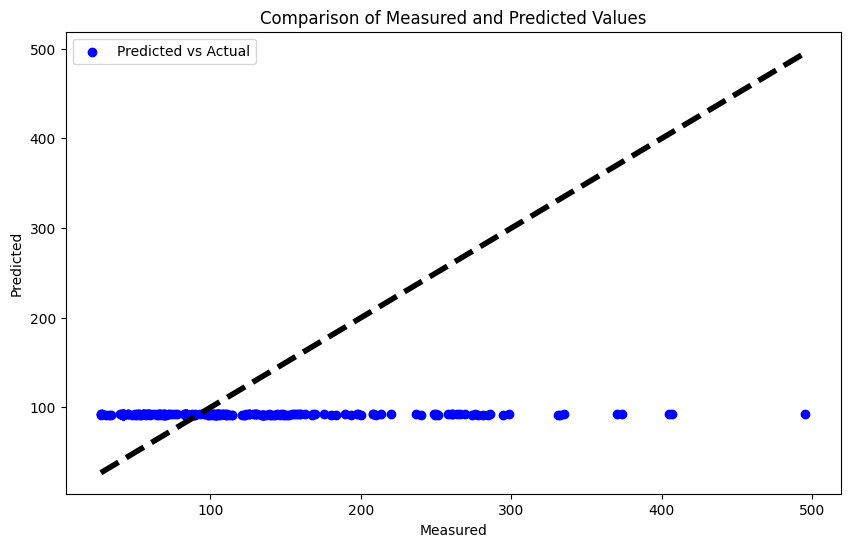

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

"""Preparing the Dataset"""
X = final_ndvi.drop(columns=['ugc_code', 'ndvi_7', 'ndvi_1', 'ndvi_avg', 'yield22'])  # Exclude non-NDVI columns and ndvi_7
y = final_ndvi['yield22']

"""Splitting the Dataset"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline and parameter grid
pipeline = make_pipeline(StandardScaler(), SVR())
param_grid = {
    'svr__C': [0.1, 1.0, 10.0],
    'svr__epsilon': [0.01, 0.1, 0.2],
    'svr__kernel': ['linear', 'rbf']
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Evaluating the best model
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plotting measured vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Plotting the identity line
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Comparison of Measured and Predicted Values')
plt.legend()
plt.show()